# Summarization with Claude

## Introduction

Summarization is a crucial task in natural language processing that involves condensing large amounts of text into shorter, more digestible formats while retaining key information. In today's information-rich world, the ability to quickly extract and synthesize essential points from lengthy documents is invaluable across various industries and applications.

This guide focuses on leveraging Claude's capabilities for summarization, with a particular emphasis on legal documents. Legal documents can often be long and tedious to read – particularly where there is a lot of fine print and legal terminology. We'll explore techniques for effective summarization of such documents, methods for evaluating summary quality, and strategies for systematically improving summarization performance.

Key aspects we'll cover include:
- Crafting effective prompts for summarization
- Extracting specific metadata from documents
- Handling longer documents beyond typical token limits
- Evaluating summary quality using automated methods (e.g., ROUGE scores and [Promptfoo](https://www.promptfoo.dev/) custom methods)
- Iteratively improving summarization performance
- General conclusive tips on how to optimize your summarization workflows

By the end of this guide, you'll have a solid understanding of how to implement and refine summarization tasks using Claude, along with a framework for applying these techniques to your own specific use cases.

Before we get going, it's worth talking about evaluations in this guide. Evaluating the quality of summarization is a notoriously challenging task. Unlike many other natural language processing tasks, summarization evaluation often lacks clear-cut, objective metrics. The process can be highly subjective, with different readers valuing different aspects of a summary. Traditional empirical methods like ROUGE scores, while useful, have limitations in capturing nuanced aspects such as coherence, factual accuracy, and relevance. Moreover, the "best" summary can vary depending on the specific use case, target audience, and desired level of detail. Despite these challenges, we explore several different approaches in this guide that can be leveraged, combining automated metrics, regular expressions, and task-specific criteria. In this guide we recognize that the most effective approach often involves a tailored combination of techniques suited to the particular summarization task at hand.

## Table of Contents

1. [Setup](#setup)
2. [Data Preparation](#data-preparation)
3. [Basic Summarization](#basic-summarization)
4. [Multi-Shot Basic Summarization](#multi-shot-basic-summarization)
5. [Advanced Techniques](#advanced-techniques)
    - [Guided Summarization](#guided-summarization)
    - [Domain-Specific Guided Summarization](#domain-specific-guided-summarization)
    - [Meta-Summarization](#including-the-context-of-the-entire-document-meta-summarization)
6. [Summary Indexed Documents: An Advanced RAG Approach](#summary-indexed-documents-an-advanced-rag-approach)
    - [Best Practices for Summarization Rag](#best-practices-for-summarization-rag)
7. [Evaluations](#evaluations)
8. [Iterative Improvement](#iterative-improvement)
9. [Conclusion and Best Practices](#conclusion-and-best-practices)

## Setup

To complete this guide, you'll need to install the following packages:
- anthropic 
- pypdf
- pandas
- matplotlib
- sklearn
- numpy
- rouge-score
- nltk
- seaborn
- [promptfoo](https://www.promptfoo.dev/) (for evaluation)

You'll also need an Anthropic API key.

Let's start by installing the required packages and setting up our environment:

In [1]:
# install packages
!pip install anthropic pypdf pandas matplotlib numpy rouge-score nltk seaborn --quiet

In [2]:
import os
import re
import anthropic
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict, Tuple
import json
import seaborn as sns

# Set up Anthropic client
# You can set up a .env file with your API key to keep it private, and import it like so:
# from dotenv import load_dotenv
# load_dotenv()

# or add your key directly
api_key = 'ANTHROPIC_API_KEY' # Replace ANTHROPIC_API_KEY with your actual API key
client = anthropic.Anthropic(api_key=api_key)

print("Setup complete!")

Setup complete!


## Data Preparation
Before we can begin summarizing documents, we need to prepare our data. This involves extracting text from PDFs, cleaning the text, and ensuring it's ready for input into our language model. For the purposes of this demo, we have sourced a [publicly available Sublease Agreement from the sec.gov website](https://www.sec.gov/Archives/edgar/data/1045425/000119312507044370/dex1032.htm). 

If you have any PDF you want to test this on, feel free to import it into this directory, and then change the file path below. **If you want to just use a text blob via copy and paste, skip this step and define `text = <text blob>`**.

Here's a set of functions to handle this process:

In [3]:
import pypdf
import re

pdf_path = "data/Sample Sublease Agreement.pdf"

def extract_text_from_pdf(pdf_path):
    with open(pdf_path, 'rb') as file:
        reader = pypdf.PdfReader(file)
        text = ""
        for page in reader.pages:
            text += page.extract_text() + "\n"
    return text

def clean_text(text):
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove page numbers
    text = re.sub(r'\n\s*\d+\s*\n', '\n', text)
    return text.strip()

def prepare_for_llm(text, max_tokens=180000):
    # Truncate text to fit within token limit (approximate)
    return text[:max_tokens * 4]  # Assuming average of 4 characters per token

def get_llm_text(path):
    extracted_text = extract_text_from_pdf(path)
    cleaned_text = clean_text(extracted_text)
    llm_ready_text = prepare_for_llm(cleaned_text)
    return llm_ready_text

# You can now use get_llm_text in your LLM prompt
text = get_llm_text(pdf_path)
print(text[:500])

EX-10.32 7 dex1032.htm SUBLEASE AGREEMENT Exhibit 10.32 SUBLEASE AGREEMENT THIS SUBLEASE AGREEMENT (“Sublease ”), is dated as of April 1, 2006, by and between COHEN BROTHERS, LLC d/b/a COHEN & COMP ANY (“Sublessor ”) and TABERNA CAPIT AL MANAGEMENT , LLC (“Sublessee ”), collectively , the “ Parties ” and each a “ Party ”. WHEREAS, Sublessor is the lessee under a written lease agreement dated June 22, 2005 wherein Brandywine Cira, L.P ., a Delaware limited partnership (“ Lessor ”), leased Suite N


This setup allows us to easily process PDF documents and prepare them for summarization. In the next section, we'll start with a basic summarization approach and then build upon it with more advanced techniques.

## Basic Summarization

Let's start with a simple summarization function using Claude. This is a simple attempt at using Claude to summarize the text from the document above. As we progress through this guide, we will improve on this method.

One thing to note is while this might seem basic, we are actually using some important functionality of Claude already. One piece worth noting is the use of the assistant role and stop sequences. The assistant preamble tees Claude up to include the summary directly after the final phrase `<summary>`. The stop sequence `</summary>` then tells Claude to stop generating. This is a pattern we will continue to use throughout this guide.

In [4]:
def basic_summarize(text, max_tokens=1000):

    # Prompt the model to summarize the text
    prompt = f"""Summarize the following text in bullet points. Focus on the main ideas and key details:
    {text}
    """

    response = client.messages.create(
            model="claude-3-5-sonnet-20241022",
            max_tokens=max_tokens,
            system="You are a legal analyst known for highly accurate and detailed summaries of legal documents.",
            messages=[
                {
                    "role": "user", 
                    "content": prompt
                },
                {
                    "role": "assistant",
                    "content": "Here is the summary of the legal document: <summary>" 
                }
            ],
            stop_sequences=["</summary>"]
        )

    return response.content[0].text

In [5]:
basic_response = basic_summarize(text, max_tokens=1000)

print(basic_response)



Key Points:
•Between parties: COHEN BROTHERS, LLC d/b/a COHEN & COMPANY (Sublessor) and TABERNA CAPITAL MANAGEMENT, LLC (Sublessee).
•Signed on April 1, 2006.
•Premises: 2,000 square feet of office space in Suite 1703 in the Cira Center at 2929 Arch Street, Philadelphia.

Major Terms:
•Term: 5 years starting April 1, 2006
•Payment: Fixed rent increases annually from $34.50/sf to $37.34/sf over the term.
•Utilities: Tenant pays for electricity and pro rata share of building expenses.
•Use: General office use only.
•Assignment/Subletting: Requires prior written consent of landlord.

Key Obligations:
•Tenant must maintain insurance including liability and property insurance.  
•Tenant responsible for interior maintenance/condition of the premises.
•Tenant must comply with all building rules and regulations.
•Tenant must maintain premises in good order and repair.

Notable Provisions:
•Sublessor can recapture premises if tenant tries to assign/sublet without proper consent.
•Default prov

This basic approach provides a simple summary, but it may not capture all the nuances we need for legal or financial documents. As you'll notice too, when you rerun the cell above, there is no standard, formalized output. Instead, we retrieve a basic summarization of the document, without much structured output to parse through. This makes it harder to read, more difficult to trust (how do we know it didn't miss something?) and thus trickier to use in any real world context.

Let's see if we can tweak our prompt to get a more structure version of our summary.

## Multi-Shot Basic Summarization

It's pretty cool that we can summarize massive documents so fast, but we can do even better. Let's try adding a few examples to our prompt to see if we can improve the output and create a bit of structure in our output before we move on to even more advanced techniques. 

Note, here we haven't really change the actual format of the request, although we have appended 2 additional pieces: 

1. We've told the model "do not preamble". This can often be a good idea when it comes to constraining the model output to just the answer we want, without that initial form conversational angle you might be familiar with if you've used Claude before. It's particularly important when we aren't using other "instructions" within the prompt (as we might do later in this guide).
2. We append 3 examples of summarized documents. This is called few-shot or multi-shot learning, and it can help the model understand what we're looking for.

Let's see how the output changes:

In [6]:
# We import from our data directory to save space in our notebook
from data.multiple_subleases import document1, document2, document3, sample1, sample2, sample3

def basic_summarize_multishot(text, max_tokens=1000):

    # Prompt the model to summarize the text
    prompt = f"""Summarize the following text in bullet points. Focus on the main ideas and key details:
        {text}

    Do not preamble.

    Use these examples for guidance in summarizing:

    <example1>
        <original1>
            {document1}
        </original1>

        <summary1>
            {sample1}
        </summary1>
    </example1>

    <example2>
        <original2>
            {document2}
        </original2>

        <summary2>
            {sample2}
        </summary2>
    </example2>

    <example3>
        <original3>
            {document3}
        </original3>

        <summary3>
            {sample3}
        </summary3>
    </example3>
    """

    response = client.messages.create(
            model="claude-3-5-sonnet-20241022",
            max_tokens=max_tokens,
            system="You are a legal analyst known for highly accurate and detailed summaries of legal documents.",
            messages=[
                {
                    "role": "user", 
                    "content": prompt
                },
                {
                    "role": "assistant",
                    "content": "Here is the summary of the legal document: <summary>" 
                }
            ],
            stop_sequences=["</summary>"]
        )

    return response.content[0].text

In [7]:
basic_multishot_response = basic_summarize_multishot(text, max_tokens=1000)

print(basic_multishot_response)



Description: This is a sublease agreement between Cohen Brothers, LLC (Sublessor) and Taberna Capital Management, LLC (Sublessee) for office space in Philadelphia.

<parties involved>
Sublessor: Cohen Brothers, LLC d/b/a Cohen & Company
Sublessee: Taberna Capital Management, LLC
Original lessor: Brandywine Cira, L.P.
</parties involved>

<property details> 
Address: 2929 Arch Street, Suite 1703, Philadelphia, PA
Description: 2,000 square feet of office space with access to file space, printers, copiers, kitchen, conference rooms
Permitted use: General office use
</property details>

<term and rent>
Start date: April 1, 2006
End date: 5 years from start date
Monthly rent:
• Months 1-12: $5,750
• Months 13-24: $5,865
• Months 25-36: $5,981.67
• Months 37-48: $6,101.67
• Months 49-60: $6,223.33
</term and rent>

<responsibilities>
Utilities: Not explicitly specified
Maintenance: Not explicitly specified
Repairs: Tenant responsible for damage repairs
Insurance: Tenant required to maintai

If you look at the examples we provided, you see see that the format of the output above is the same *(go to data/<any of the .txt files> to see)*. This is interesting – we didn't explicitly tell Claude to follow the format of the examples, but it seems to have picked up on it anyway. This illustrates the power of few-shot learning, and how Claude can generalize from a few examples to new inputs.

## Advanced Summarization Techniques

### Guided Summarization

Guided summarization is where we explicitly define a framework for the model to abide by in it's summarization task. We can do this all via prompting, changing the details of the prompt to guide Claude to be more or less verbose, include more or less technical terminology, or provide a higher or lower level summary of the context at hand. For legal documents, we can guide the summarization to focus on specific aspects.

Note, we could likely accomplish the same formatted output we reveal below via examples (which we explored above)!

In [8]:
def guided_legal_summary(text, max_tokens=1000):

    # Prompt the model to summarize the text
    prompt = f"""Summarize the following legal document. Focus on these key aspects:

    1. Parties involved
    2. Main subject matter
    3. Key terms and conditions
    4. Important dates or deadlines
    5. Any unusual or notable clauses

    Provide the summary in bullet points under each category.

    Document text:
    {text}
    
    """

    response = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=max_tokens,
        system="You are a legal analyst known for highly accurate and detailed summaries of legal documents.",
        messages=[
            {
                "role": "user", 
                "content": prompt
            },
            {
                "role": "assistant",
                "content": "Here is the summary of the legal document: <summary>" 
            }
        ],
        stop_sequences=["</summary>"]
    )

    return response.content[0].text

In [9]:
# Example usage
legal_summary = guided_legal_summary(text)
print(legal_summary)



1. Parties Involved
- Sublessor: Cohen Brothers, LLC d/b/a Cohen & Company
- Sublessee: Taberna Capital Management, LLC
- Original Landlord: Brandywine Cira, L.P. (Master Lease landlord)

2. Main Subject Matter
- Sublease agreement for Suite 1703 at Cira Centre, 2929 Arch Street, Philadelphia, PA
- 2,000 square feet of office space within the Master Premises of 13,777 rentable square feet
- Includes furniture, file space, printers, copiers, kitchen, conference room facilities and receptionist/secretarial services

3. Key Terms and Conditions
- Initial Term: 5 years from April 1, 2006 
- Fixed Rent: Escalating annual rent schedule starting at $34.50/sq ft in Year 1 ($69,000 annually) up to $37.34/sq ft in Year 5 ($74,680 annually)
- Pro rata share of operating expenses and utilities
- No assignment or subletting without Sublessor's prior written consent
- Sublessee takes premises "AS IS"
- Sublessee must maintain required insurance coverage
- Default provisions for non-payment, breach

This certainly makes it easier to parse out the most relevant sections of the document and understand the implications of specific line items and important clauses.

### Domain-Specific Guided Summarization

You could give the above guided summarization prompt to any type of document, but we can make it even more powerful by tailoring it to specific document types. For example, if we know we're dealing with a sublease agreement, we can guide the model to focus on the most relevant legal terms and concepts for that particular type of document. This would be most relevant when we are working on a specific use case using Claude and explicitly know the most relevant values we want to extract.

Here's an example of how we might modify our guided summarization function for sublease agreements. Note that we'll also add the 'model' as an additional parameter to our function so that we can more easily choose different models for summarization based upon the task:



In [10]:
def guided_sublease_summary(text, model="claude-3-5-sonnet-20241022", max_tokens=1000):

    # Prompt the model to summarize the sublease agreement
    prompt = f"""Summarize the following sublease agreement. Focus on these key aspects:

    1. Parties involved (sublessor, sublessee, original lessor)
    2. Property details (address, description, permitted use)
    3. Term and rent (start date, end date, monthly rent, security deposit)
    4. Responsibilities (utilities, maintenance, repairs)
    5. Consent and notices (landlord's consent, notice requirements)
    6. Special provisions (furniture, parking, subletting restrictions)

    Provide the summary in bullet points nested within the XML header for each section. For example:

    <parties involved>
    - Sublessor: [Name]
    // Add more details as needed
    </parties involved>
    
    If any information is not explicitly stated in the document, note it as "Not specified". Do not preamble.

    Sublease agreement text:
    {text}
    
    """

    response = client.messages.create(
        model=model,
        max_tokens=max_tokens,
        system="You are a legal analyst specializing in real estate law, known for highly accurate and detailed summaries of sublease agreements.",
        messages=[
            {
                "role": "user", 
                "content": prompt
            },
            {
                "role": "assistant",
                "content": "Here is the summary of the sublease agreement: <summary>" 
            }
        ],
        stop_sequences=["</summary>"]
    )

    return response.content[0].text

In [11]:
# Example usage
sublease_summary = guided_sublease_summary(text)
print(sublease_summary)



<parties involved>
- Sublessor: Cohen Brothers, LLC (d/b/a Cohen & Company) 
- Sublessee: Taberna Capital Management, LLC
- Original Lessor: Brandywine Cira, L.P. (Master Lease holder)
</parties involved>

<property details>
- Address: 2929 Arch Street, Suite 1703, Philadelphia, PA
- Description: 2,000 square feet of office space in Suite 1703 
- Permitted Use: General office use
- Includes: Access to file space, printers, copiers, kitchen, conference rooms, receptionist/secretarial services
</property details>

<term and rent>
- Start Date: April 1, 2006
- End Date: 5 years from commencement
- Monthly Rent: Escalating schedule starting at $5,750 in year 1 up to $6,223.33 in year 5
- Security Deposit: Not specified
</term and rent>

<responsibilities>
- Utilities: Sublessee pays proportional share of utilities and operating expenses
- Maintenance: Sublessor responsible for base building maintenance
- Repairs: Sublessee responsible for repairs due to its use
- Insurance: Sublessee mus

Because we decided to output each section of the summary in XML tags, we can now parse them individually out like so (this could also be done via JSON or any other format):

In [12]:
import re

def parse_sections_regex(text):
    pattern = r'<(.*?)>(.*?)</\1>'
    matches = re.findall(pattern, text, re.DOTALL)
    
    parsed_sections = {}
    for tag, content in matches:
        items = [item.strip('- ').strip() for item in content.strip().split('\n') if item.strip()]
        parsed_sections[tag] = items
    
    return parsed_sections


# Parse the sections
parsed_sections = parse_sections_regex(sublease_summary)

# Check if parsing was successful
if isinstance(parsed_sections, dict) and 'parties involved' in parsed_sections:
    print("Parties involved:")
    for item in parsed_sections['parties involved']:
        print(f"- {item}")
else:
    print("Error: Parsing failed or 'parties involved' section not found.")
    print("Parsed result:", parsed_sections)

Parties involved:
- Sublessor: Cohen Brothers, LLC (d/b/a Cohen & Company)
- Sublessee: Taberna Capital Management, LLC
- Original Lessor: Brandywine Cira, L.P. (Master Lease holder)


### Including the Context of Multiple Documents (Meta-Summarization)

What if we have a lot of documents related to the same client? We can use a chunking method in order to handle this. This is a technique that involves breaking down documents into smaller, manageable chunks and then processing each chunk separately. We can then combine the summaries of each chunk to create a meta-summary of the entire document. This can be particularly helpful when we want to summarize a large number of documents or when we want to summarize a single document that is very long.

Here's an example of how we might do this:

In [13]:
from data.multiple_subleases import document1, document2, document3

def chunk_text(text, chunk_size=2000):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

def summarize_long_document(text, max_tokens=2000):

    chunks = chunk_text(text)

    # Iterate over chunks and summarize each one
    # We use guided_legal_summary here, but you can use basic_summarize or any other summarization function
    # Note that we'll also use haiku for the interim summaries, and the 3.5 sonnet for the final summary
    chunk_summaries = [guided_sublease_summary(chunk, model="claude-3-haiku-20240307", max_tokens=max_tokens) for chunk in chunks]
    
    final_summary_prompt = f"""
    
    You are looking at the chunked summaries of multiple documents that are all related. Combine the following summaries of the document from different truthful sources into a coherent overall summary:

    {"".join(chunk_summaries)}

    1. Parties involved (sublessor, sublessee, original lessor)
    2. Property details (address, description, permitted use)
    3. Term and rent (start date, end date, monthly rent, security deposit)
    4. Responsibilities (utilities, maintenance, repairs)
    5. Consent and notices (landlord's consent, notice requirements)
    6. Special provisions (furniture, parking, subletting restrictions)

    Provide the summary in bullet points nested within the XML header for each section. For example:

    <parties involved>
    - Sublessor: [Name]
    // Add more details as needed
    </parties involved>
    
    If any information is not explicitly stated in the document, note it as "Not specified".

    Summary:
    """

    response = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=max_tokens,
        system="You are a legal expert that summarizes notes on one document.",
        messages=[
            {
                "role": "user", 
                "content": final_summary_prompt
            },
            {
                "role": "assistant",
                "content": "Here is the summary of the legal document: <summary>" 
            }
        ],
        stop_sequences=["</summary>"]
    )
    
    return response.content[0].text

# Example usage
# combine 3 documents (all related) together
text = document1 + document2 + document3
long_summary = summarize_long_document(text)
print(long_summary)


<parties involved>
- Sublessor: Apex Innovations, Inc. (Delaware corporation) later identified as TechHub Enterprises, LLC
- Sublessee: NanoSphere Solutions, Inc. and Quantum Dynamics, LLC (California LLC)
- Original Lessor: Innovate Properties, LLP
</parties involved>

<property details>
- Address: 9876 Innovation Park, Building C, San Francisco, CA 94107
- Description: Approximately 15,000-25,000 square feet of office and laboratory space
- Permitted Use: General office purposes, research and development, and laboratory uses consistent with BSL-2 facility requirements
</property details>

<term and rent>
- Start Date: September 1, 2023
- End Date: August 31, 2026 (with option to extend for 3-5 additional years)
- Monthly Rent: Starting at $75,000/month with annual 3% increases
- Security Deposit: $450,000-$787,500
</term and rent>

<responsibilities>
- Utilities: Sublessee responsible for all utilities and services, including electricity, gas, water, sewer, telephone, internet, and 

## Summary Indexed Documents: An Advanced RAG Approach

Summary Indexed Documents is an advanced approach to Retrieval-Augmented Generation (RAG) that operates at the document level. 

This method offers several advantages over traditional RAG techniques, particularly in scenarios involving large documents or when precise information retrieval is crucial.

#### How It Works

1. Document Summarization: Generate concise summaries for each document in your corpus (subset of text is queried and quickly summarized).
2. Context Window Optimization: Ensure all summaries fit within the context window of your language model.
3. Relevancy Scoring: Ask a model to rank the relevance of each summary to the query being asked.
4. Reranking (Optional): Apply reranking techniques to further refine and compress the top-K results.
5. Answer the query at-hand.

There are some distinct advantages to this approach: 
- More efficient way of ranking documents for retrieval, using less context than traditional RAG methods.
- Superior Performance on Specific Tasks: Outperforms other RAG methods, consistently ranking the correct document first.
- Optimized Information Retrieval: Reranking helps compress results, ensuring the most concise and relevant information is presented to the model.

In [18]:
class LegalSummaryIndexedDocuments:

    def __init__(self, client):
        self.client = client # Claude client
        self.documents: List[Dict[str, str]] = [] # List of docs to store
        self.summaries: List[str] = []

    def add_document(self, doc_id: str, content: str):
        # Adds a document to the index
        self.documents.append({"id": doc_id, "content": content})

    def generate_summaries(self):
        # Generates summaries for all documents in the index
        for doc in self.documents:
            summary = self._generate_legal_summary(doc["content"])
            self.summaries.append(summary)

    def _generate_legal_summary(self, content: str) -> str:

        # Note how we constrain the content to a maximum of 2000 words. We do this because we don't need that much information for the intial ranking.
        prompt = f"""
        Summarize the following sublease agreement. Focus on these key aspects:

        1. Parties involved (sublessor, sublessee, original lessor)
        2. Property details (address, description, permitted use)
        3. Term and rent (start date, end date, monthly rent, security deposit)
        4. Responsibilities (utilities, maintenance, repairs)
        5. Consent and notices (landlord's consent, notice requirements)
        6. Special provisions (furniture, parking, subletting restrictions)

        Provide the summary in bullet points nested within the XML header for each section. For example:

        <parties involved>
        - Sublessor: [Name]
        // Add more details as needed
        </parties involved>
        
        If any information is not explicitly stated in the document, note it as "Not specified".

        Sublease agreement text:
        {content[:2000]}...

        Summary:
        """

        response = client.messages.create(
            model="claude-3-5-sonnet-20241022",
            max_tokens=500,
            temperature=0.2,
            messages=[
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": "Here is the summary of the legal document: <summary>"}
            ],
            stop_sequences=["</summary>"]        
        )
        return response.content[0].text

    def rank_documents(self, query: str, top_k: int = 3) -> List[Tuple[str, float]]:
        """
        Rank documents based on their relevance to the given query.
        We use Haiku here as a cheaper, faster model for ranking. 
        """
        ranked_scores = []
        for summary in self.summaries:

            prompt=f"Legal document summary: {summary}\n\nLegal query: {query}\n\nRate the relevance of this legal document to the query on a scale of 0 to 10. Only output the numeric value:"

            response = client.messages.create(
                model="claude-3-haiku-20240307",
                max_tokens=2,
                temperature=0,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
            ranked_score = float(response.content[0].text)
            ranked_scores.append(ranked_score)

        ranked_indices = np.argsort(ranked_scores)[::-1][:top_k]
        return [(self.documents[i]["id"], ranked_scores[i]) for i in ranked_indices]

    def extract_relevant_clauses(self, doc_id: str, query: str) -> List[str]:
        """
        Extracts relevant clauses from a document based on a query.
        """
        doc_content = next(doc["content"] for doc in self.documents if doc["id"] == doc_id)
        
        prompt = f"""
        Given the following legal query and document content, extract the most relevant clauses or sections and write the answer to the query. 
        Provide each relevant clause or section separately, preserving the original legal language:

        Legal query: {query}

        Document content: {doc_content}...

        Relevant clauses or sections (separated by '---'):"""

        response = client.messages.create(
                model="claude-3-5-sonnet-20241022",
                max_tokens=1000,
                temperature=0,
                messages=[
                    {"role": "user", "content": prompt}
                ]
            )
        
        clauses = re.split(r'\n\s*---\s*\n', response.content[0].text.strip())
        return [clause.strip() for clause in clauses if clause.strip()]

In [19]:
from data.multiple_subleases import document1, document2, document3

lsid = LegalSummaryIndexedDocuments(client=client)

# Add documents
lsid.add_document("doc1", document1)
lsid.add_document("doc2", document2)
lsid.add_document("doc3", document3)

# Generate summaries - this would happen at ingestion
lsid.generate_summaries()

# Rank documents for a legal query
legal_query = "What contract is for the sublessor Apex Innovations, LLC?"
ranked_results = lsid.rank_documents(legal_query)

print("Initial ranking:", ranked_results)

# Extract relevant clauses from the top-ranked document
top_doc_id = ranked_results[0][0]
relevant_clauses = lsid.extract_relevant_clauses(top_doc_id, legal_query)

print("\nRelevant clauses from the top-ranked document:")
for i, clause in enumerate(relevant_clauses[1:], 1):
    print(f"Clause {i}: {clause}")

Initial ranking: [('doc1', 8.0), ('doc3', 0.0), ('doc2', 0.0)]

Relevant clauses from the top-ranked document:
Clause 1: COMMERCIAL SUBLEASE AGREEMENT

THIS COMMERCIAL SUBLEASE AGREEMENT (hereinafter referred to as the "Sublease") is made and entered into on this 15th day of August, 2023 (the "Effective Date"), by and between:

SUBLESSOR: Apex Innovations, Inc., a Delaware corporation with its principal place of business at 1234 Tech Boulevard, Suite 5000, San Francisco, CA 94105 (hereinafter referred to as the "Sublessor")
Clause 2: WHEREAS, Sublessor is the Tenant under that certain Master Lease Agreement dated January 1, 2020 (hereinafter referred to as the "Master Lease"), wherein Innovate Properties, LLP (hereinafter referred to as the "Master Lessor") leased to Sublessor those certain premises consisting of approximately 50,000 square feet of office space located at 9876 Innovation Park, Building C, Floors 10-12, San Francisco, CA 94107 (hereinafter referred to as the "Master Pre

### Best Practices for Summarization RAG

- Optimal Summary Length: Experiment with different summary lengths to find the right balance between conciseness and informativeness.
- Iterative Reranking: Consider multiple rounds of reranking for more precise results, especially with larger document sets.
- Caching: Implement caching mechanisms for summaries and initial rankings to improve performance on repeated queries.

Summary Indexed Documents offer a powerful approach to RAG, particularly excelling in scenarios involving large documents or when precise information retrieval is crucial. By leveraging document summarization, log probability scoring, and optional reranking, this method provides an efficient and effective way to retrieve and present relevant information to language models.

## Evaluations

As mentioned in the introduction to this cookbook, evaluating the quality of a summary is hard work. This is because there are many ways to summarize a document, and different summaries may be equally valid. Depending on the use case, different aspects of a summary may be more or less important.

You can read more about our empirical methodology to prompt engineering [here](https://docs.anthropic.com/en/docs/prompt-engineering). Using a Jupyter Notebook is a great way to start prompt engineering but as your datasets grow larger and your prompts more numerous it is important to leverage tooling that will scale with you. 

In this section of the guide we will explore using [Promptfoo](https://www.promptfoo.dev/) an open source LLM evaluation toolkit. To get started head over to the `./evaluation` directory and checkout the `./evaluation/README.md`.

When you have successfully run an evaluation come back here to view the results. You can also view the results in a dynamic way using the command `npx promptfoo@latest view`, after creating some results.

/var/folders/c8/rjj6d5_15tj4qh_zhlnz9xxr0000gp/T/ipykernel_58010/2701104606.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<Figure size 1200x600 with 0 Axes>

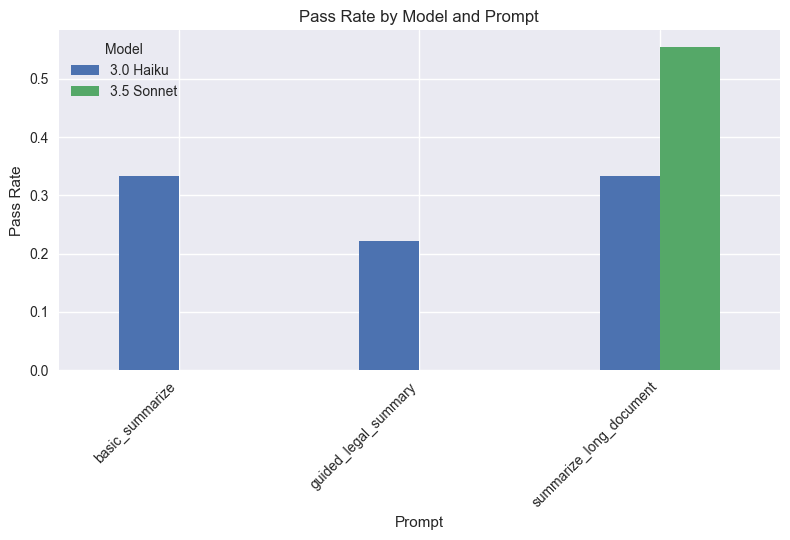

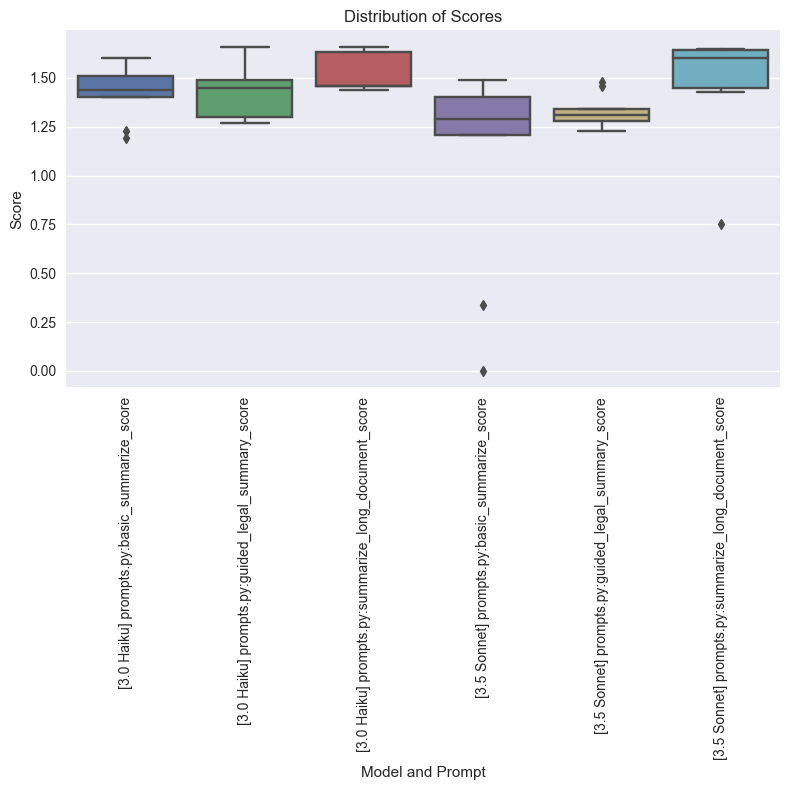

,[3.0 Haiku] prompts.py:basic_summarize_score,[3.0 Haiku] prompts.py:guided_legal_summary_score,[3.0 Haiku] prompts.py:summarize_long_document_score,[3.5 Sonnet] prompts.py:basic_summarize_score,[3.5 Sonnet] prompts.py:guided_legal_summary_score,[3.5 Sonnet] prompts.py:summarize_long_document_score
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
mean,1.423333,1.443333,1.522222,1.088889,1.330000,1.475556
std,0.135647,0.146969,0.092030,0.535547,0.086458,0.285750
min,1.190000,1.270000,1.440000,0.000000,1.230000,0.750000
25%,1.400000,1.300000,1.460000,1.210000,1.280000,1.450000
50%,1.440000,1.450000,1.460000,1.290000,1.310000,1.600000
75%,1.510000,1.490000,1.630000,1.400000,1.340000,1.640000
max,1.600000,1.660000,1.660000,1.490000,1.480000,1.650000


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

%matplotlib inline
plt.style.use('seaborn')

# Load the data
df = pd.read_csv('data/results.csv')

# Function to extract PASS/FAIL and score
def extract_result(text):
    match = re.search(r'\[(PASS|FAIL)\]\s*\((\d+\.\d+)\)', str(text))
    if match:
        return match.group(1), float(match.group(2))
    return 'UNKNOWN', 0.0

# Apply the extraction to relevant columns
for col in df.columns[2:]:
    df[f'{col}_result'], df[f'{col}_score'] = zip(*df[col].apply(extract_result))

# Prepare data for grouped accuracy score
models = ['3.5 Sonnet', '3.0 Haiku']
prompts = ['basic_summarize', 'guided_legal_summary', 'summarize_long_document']

results = []
for model in models:
    for prompt in prompts:
        col = f'[{model}] prompts.py:{prompt}_result'
        if col in df.columns:
            pass_rate = (df[col] == 'PASS').mean()
            results.append({'Model': model, 'Prompt': prompt, 'Pass Rate': pass_rate})

result_df = pd.DataFrame(results)

# 1. Grouped bar chart for accuracy scores
plt.figure(figsize=(12, 6))
result_pivot = result_df.pivot(index='Prompt', columns='Model', values='Pass Rate')
result_pivot.plot(kind='bar')
plt.title('Pass Rate by Model and Prompt')
plt.ylabel('Pass Rate')
plt.legend(title='Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2. Box plot of scores
plt.figure(figsize=(8, 8))
score_cols = [col for col in df.columns if col.endswith('_score')]
score_data = df[score_cols].melt()
sns.boxplot(x='variable', y='value', data=score_data)
plt.title('Distribution of Scores')
plt.xticks(rotation=90)
plt.xlabel('Model and Prompt')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

# Display summary statistics
summary_stats = df[[col for col in df.columns if col.endswith('_score')]].describe()
display(summary_stats)

Looking at the results, it seems like our best performer is 3.5 Sonnet, with a 66% pass rate across all evals and only 3 failed tests out of 45 (when one test fails for a prompt, it's deemed a fail). And this is just the beginning – we are using entirely notional data here that was either (a) generated by Claude, or (b) taken from the SEC gov website. We can do much better when we have real data, because we know more about the distinct problem set we are working with.

## Iterative Improvement

As we look into the eval results more, there's continued room for improvement. This is where the iterative part of prompt engineering comes in. Here are some steps we can take to improve our results:

1. Analyze the Promptfoo results to identify strengths and weaknesses – for example, it seems our contains eval was failing a lot. This is probably because some of the documents don't contain the information which is required in the XML tags. We should refine this eval if we are to accurately assess performance (but this is just an example!).
2. Refine prompts to address specific issues (e.g., improve conciseness or completeness) – we saw that multi-shot was an initial really good first attempt. This is somethign we should incorporate alongside some of the advanced techniques to improve performance further.
3. Experiment with different chunking strategies for long documents.
4. Fine-tune temperature and max_tokens parameters.
5. Implement post-processing steps to enhance summary quality.

## Conclusion and Best Practices

In this guide, we've covered a range of techniques for summarizing documents with Claude, with a focus on legal documents. Building a perfect summarization system and eval framework for summarization is an art: it requires a combination of these methods in order to succeed. As we mentioned at the beginning, summarization is a very subjective topic, and yet we've had a good stab at finding feasible ways to evaluate it and feel comfortable with our results. Always remember too – you aren't benchmarking your results against 100% accuracy. You're benchmarking against how well you could perform this complex task yourself; and with the speed and efficiency of Claude as demonstrated in this guide, you start to realise the true benefits to such a methodological approach, so you can spend time on the real decision making. 

Wrapping up the advice here, we've included some best practices to keep in mind:

1. Craft clear and specific prompts. Use things like "don't preamble" to constrain the output.
2. Use at least 2 examples.
3. Use guided summarization for domain-specific documents.
4. Implement effective, advanced strategies for long documents.
5. Regularly evaluate and refine your approach.
6. Consider the ethical implications and limitations of AI-generated summaries.